In [1]:
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from pandas_datareader.data import DataReader
import os
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from itertools import product
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, RidgeCV
from xgboost import XGBRegressor
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
df = pd.read_csv(r'..\stocks\AAPL.csv', index_col=['Date'], parse_dates=['Date'])
df = df.dropna()
# Select the proper time period for daily aggreagation
df = df['2019-01-02':'2020-12-05'].resample('D').ffill()
df.head()

High        Low       Open      Close       Volume  Adj Close
Date                                                                          
2019-01-02  39.712502  38.557499  38.722500  39.480000  148158800.0  38.505024
2019-01-03  36.430000  35.500000  35.994999  35.547501  365248800.0  34.669640
2019-01-04  37.137501  35.950001  36.132500  37.064999  234428400.0  36.149662
2019-01-05  37.137501  35.950001  36.132500  37.064999  234428400.0  36.149662
2019-01-06  37.137501  35.950001  36.132500  37.064999  234428400.0  36.149662

In [3]:
figure = go.Figure(
    data = [
            go.Candlestick(
                x = df.index, 
                low = df['Low'],
                high = df['High'],
                close = df['Close'],
                open = df['Open'],
                increasing_line_color = 'green',
                decreasing_line_color = 'red'
            )
    ]
)

figure.update_layout(
    yaxis_title = 'Apple Stock Price USD ($)',
    xaxis_title = 'Date'
)
figure.show()

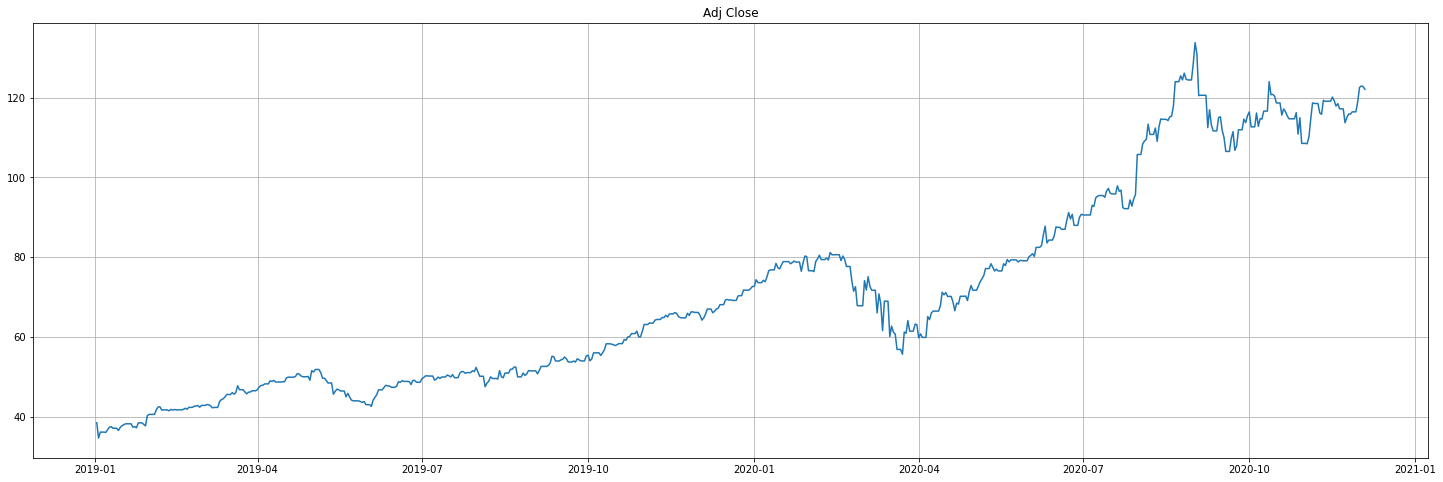

In [4]:
adj_close = df['Adj Close']
plt.figure(figsize=(25, 8))
plt.plot(df['Adj Close'])
plt.title('Adj Close')
plt.grid(True)
plt.show()

In [5]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [6]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    """
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    rolling_mean = series.rolling(window = window).mean()

    plt.figure(figsize=(25, 10))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label = "Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label = "Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series < lower_bond] = series[series < lower_bond]
            anomalies[series > upper_bond] = series[series > upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label = "Actual values")
    plt.legend(loc = "upper left")
    plt.grid(True)

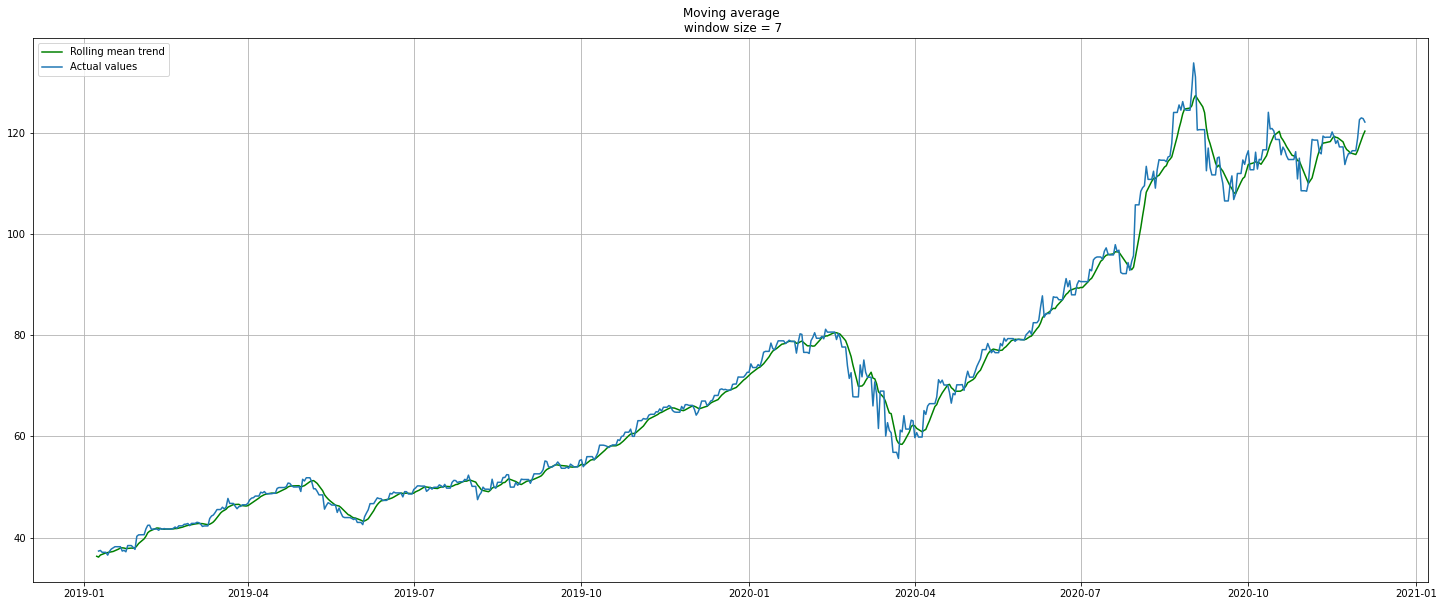

In [7]:
plotMovingAverage(df['Adj Close'], 7)

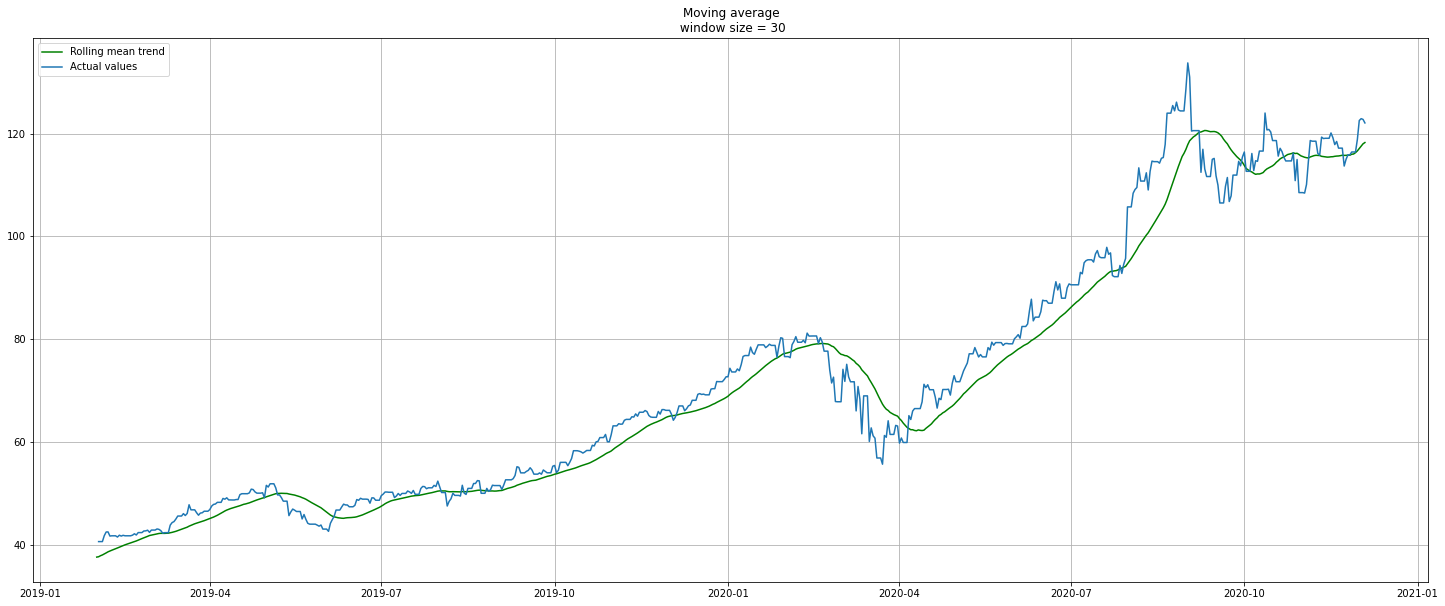

In [8]:
plotMovingAverage(df['Adj Close'], 30)

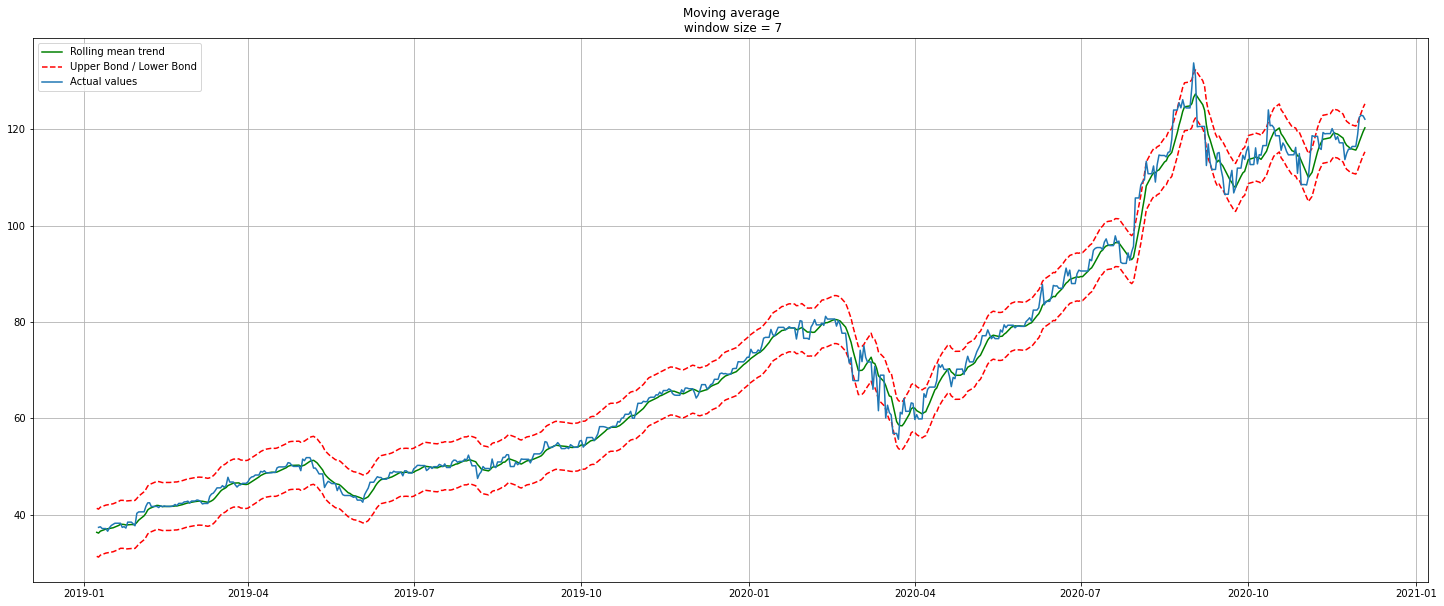

In [9]:
plotMovingAverage(df['Adj Close'], 7, plot_intervals=True)

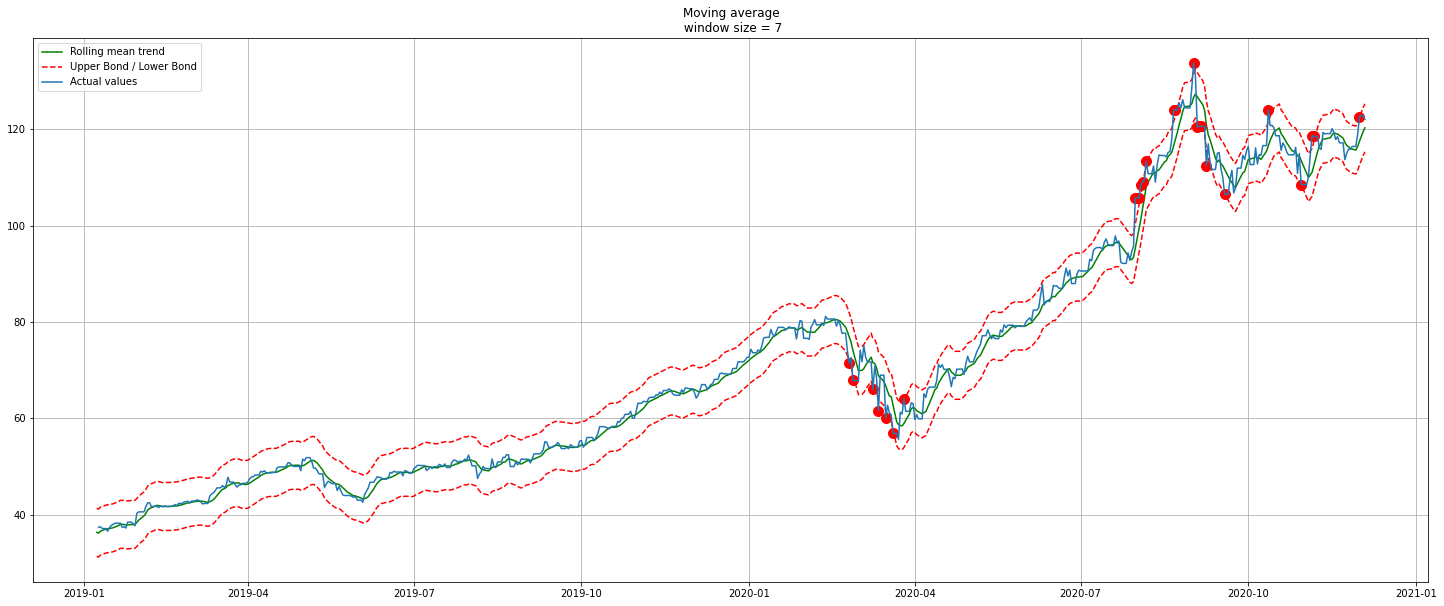

In [10]:
X = df.dropna().drop(['High'], axis=1)
new_frame = df.drop(['High', 'Low', 'Open', 'Close', 'Volume'], axis=1)

plotMovingAverage(new_frame, 7, plot_intervals=True, plot_anomalies=True)

In [11]:
def exponential_smoothing(series, alpha):
    """
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [12]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        alphas - list of floats, smoothing parameters
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize = (25, 10))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label = "Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc = "best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

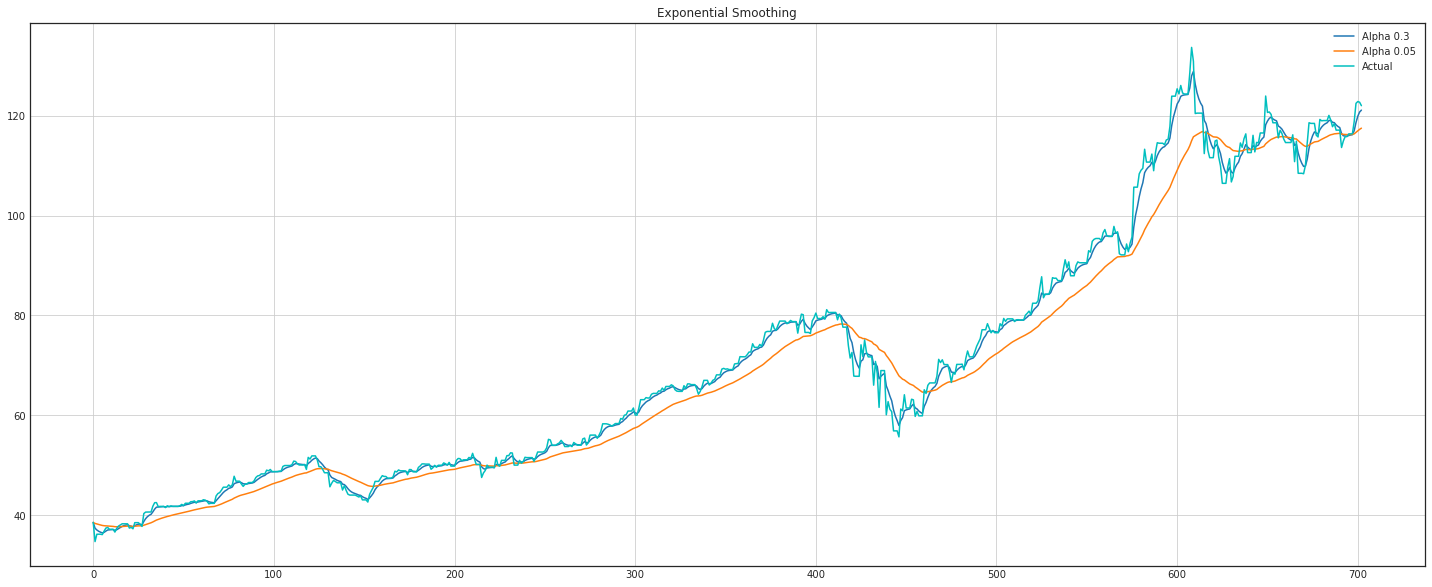

In [13]:
plotExponentialSmoothing(df['Adj Close'], [0.3, 0.05])

In [14]:
def double_exponential_smoothing(series, alpha, beta):
    """
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level - last_level) + (1-beta)*trend
        result.append(level + trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(25, 10))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

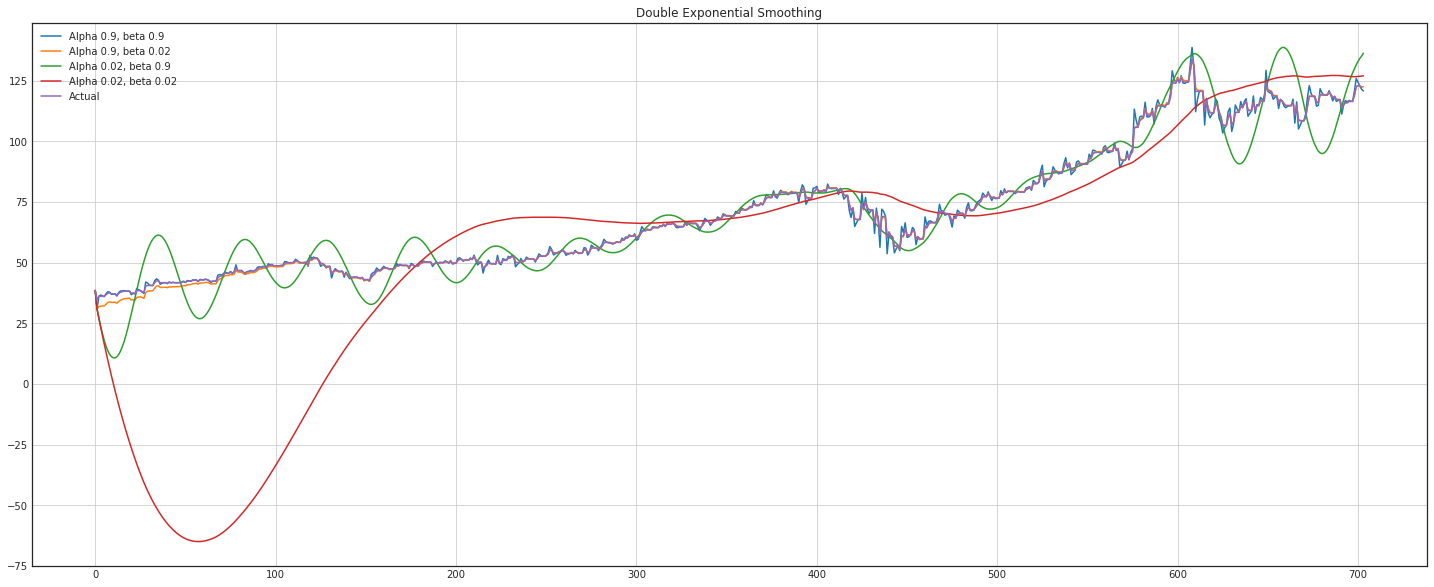

In [15]:
plotDoubleExponentialSmoothing(df['Adj Close'], alphas=[0.9, 0.02], betas=[0.9, 0.02])

In [16]:
class HoltWinters:
    """
        Holt-Winters model with the anomalies detection using Brutlag method
        # slen - length of a season
        # alpha, beta, gamma - Holt-Winters model coefficients
        # n_preds - predictions horizon
        # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    """
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series) / self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i] - season_averages[j]
            seasonals[i] = sum_of_vals_over_avg / n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [17]:
def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=7):
    """
        Returns error on CV  
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [18]:
%%time
data = df['Adj Close'][:-20] # leave some data for testing
slen = 7 # 7-day seasonality

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 100 days
model = HoltWinters(data, slen = slen, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 100, scaling_factor = 7)
model.triple_exponential_smoothing()

0.002249768714233713 0.0 0.010003521746450972
Wall time: 7.11 s


In [19]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(25, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values < model.LowerBond[:len(series)]] = \
            series.values[series.values < model.LowerBond[:len(series)]]
        anomalies[series.values > model.UpperBond[:len(series)]] = \
            series.values[series.values > model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize = 10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha = 0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha = 0.5)
        plt.fill_between(x = range(0,len(model.result)), y1 = model.UpperBond, 
                         y2 = model.LowerBond, alpha = 0.2, color = "grey")    
        
    plt.vlines(len(series), ymin = min(model.LowerBond), ymax = max(model.UpperBond), linestyles = 'dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha = 0.3, color = 'lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize = 13);

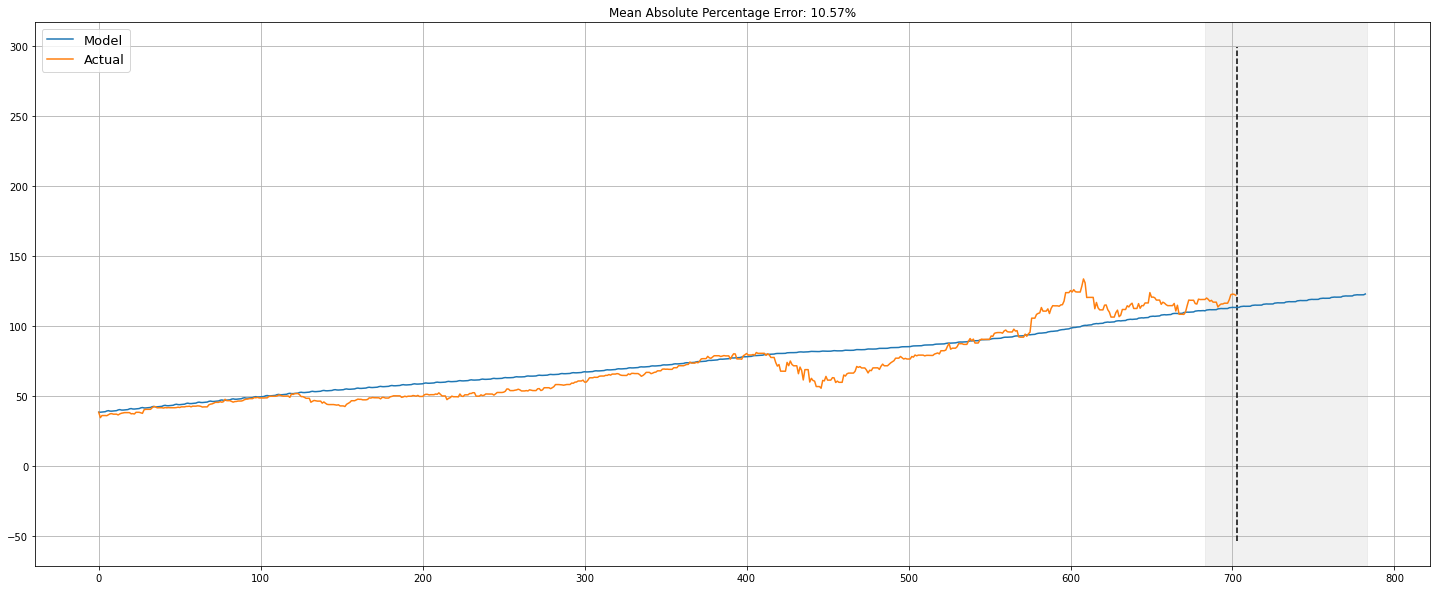

In [20]:
plotHoltWinters(df['Adj Close'])

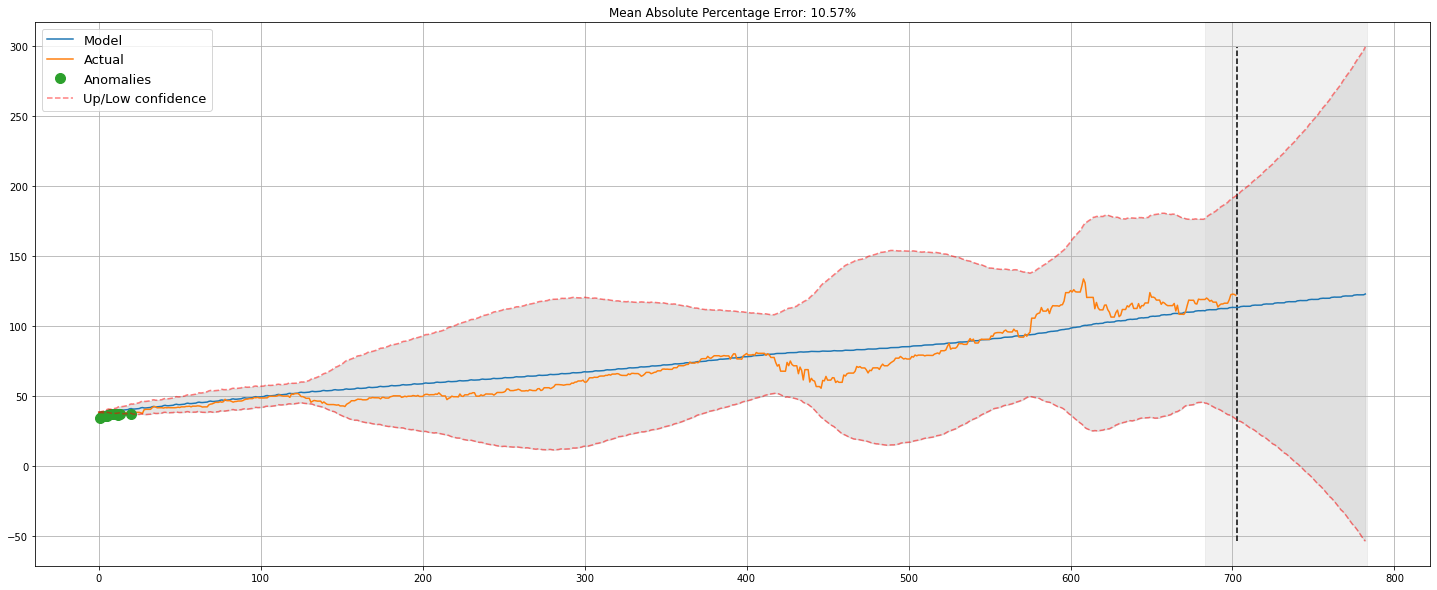

In [21]:
plotHoltWinters(df['Adj Close'], plot_intervals = True, plot_anomalies = True)

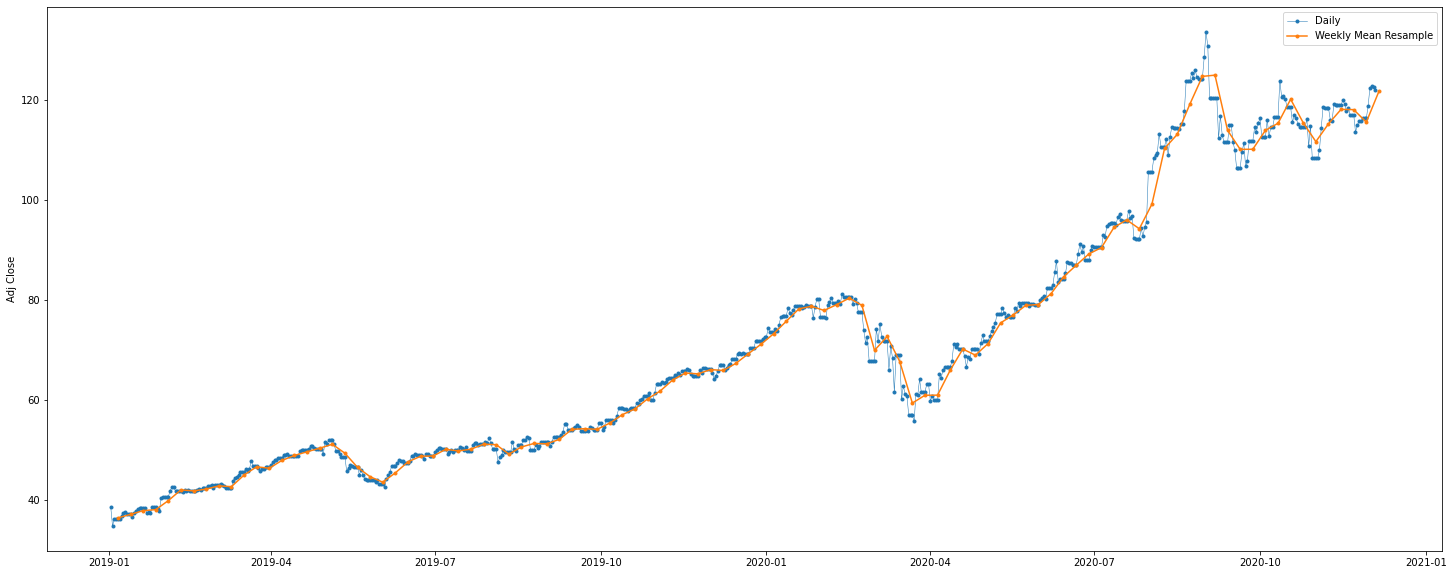

In [22]:
fig, ax = plt.subplots(figsize = (25, 10))
ax.plot(adj_close,marker = '.', linestyle = '-', linewidth = 0.5, label = 'Daily')
ax.plot(adj_close.resample('W').mean(), marker = 'o', markersize = 3, linestyle = '-', label = 'Weekly Mean Resample')
ax.set_ylabel('Adj Close')
ax.legend();

In [23]:
def tsplot(y, lags=None, figsize=(25, 10), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags = lags, ax = acf_ax)
        smt.graphics.plot_pacf(y, lags = lags, ax = pacf_ax)
        plt.tight_layout()

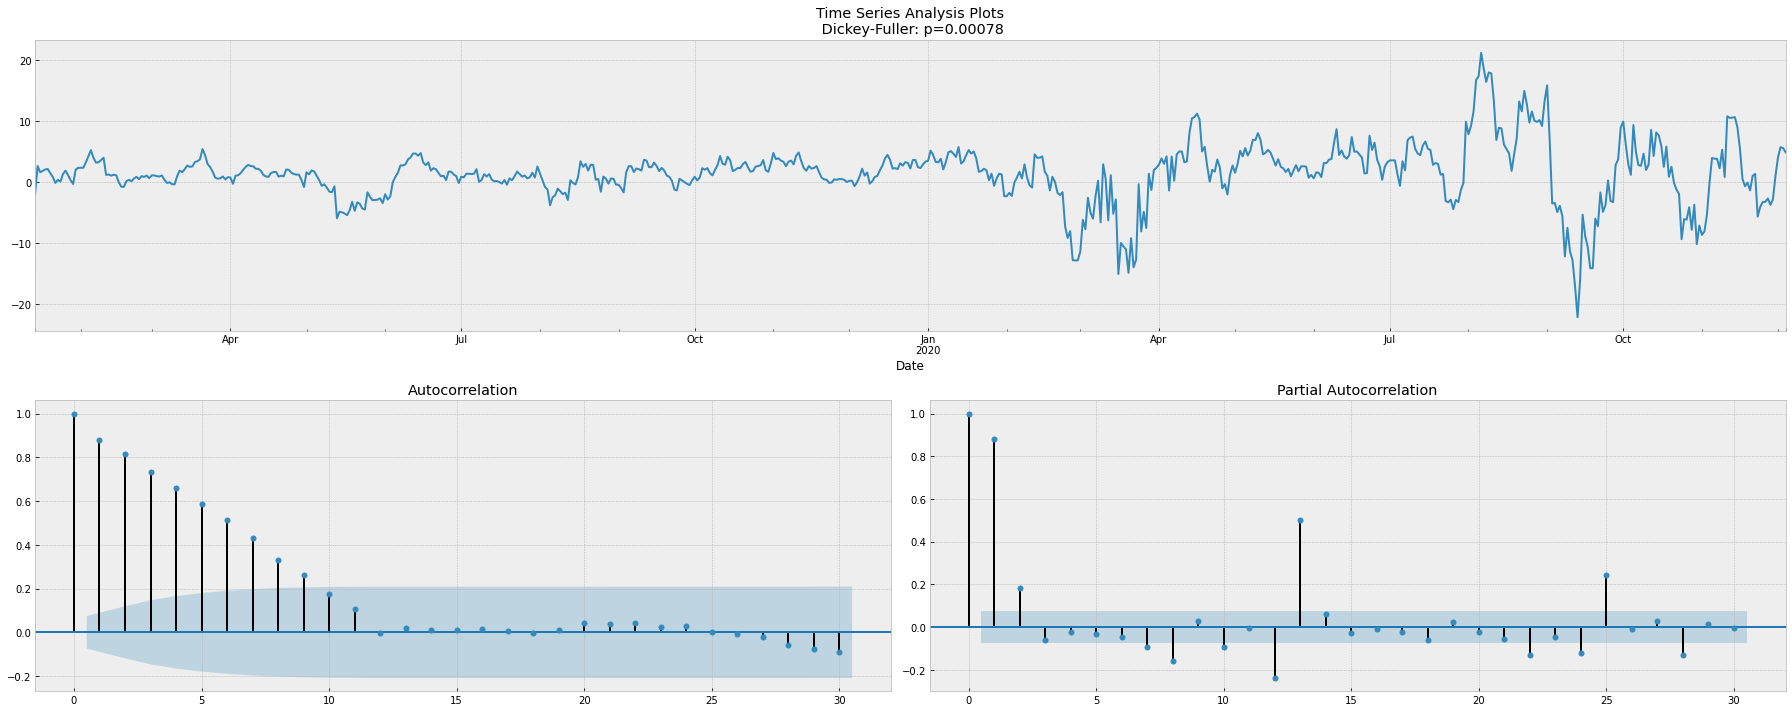

In [24]:
ads_diff = df['Adj Close'] - df['Adj Close'].shift(12)
tsplot(ads_diff[12:], lags=30)

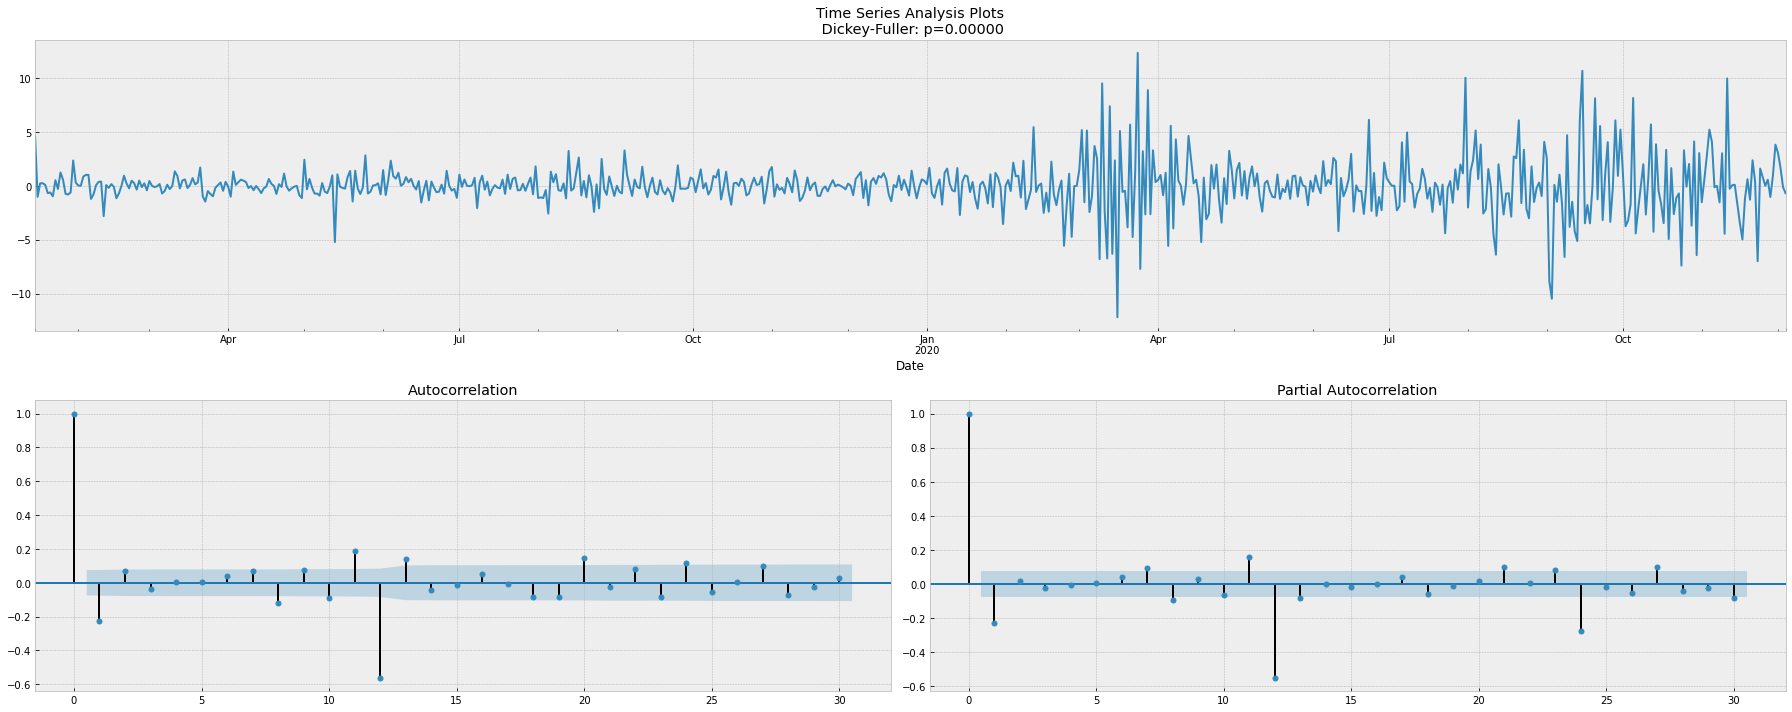

In [25]:
ads_diff = ads_diff - ads_diff.shift(1)
tsplot(ads_diff[12+1:], lags=30)

In [26]:
# setting initial values
ps = range(2, 5)
d = 1 
qs = range(2, 5)
Ps = range(0, 2)
D = 1 
Qs = range(0, 2)
s = 7

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [27]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails
        try:
            model=sm.tsa.statespace.SARIMAX(df['Adj Close'], order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, min AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [28]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

E:\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

E:\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

E:\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

E:\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

E:\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

E:\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

E:\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWar


Wall time: 2min 9s


In [29]:
result_table.head()

parameters          aic
0  (2, 2, 0, 1)  2619.740905
1  (4, 3, 0, 1)  2621.431910
2  (2, 2, 1, 1)  2621.450468
3  (3, 3, 0, 1)  2623.735515
4  (3, 3, 1, 1)  2625.476827

In [30]:
# set the parameters that give min AIC
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(df['Adj Close'], order = (p, d, q), seasonal_order = (P, D, Q, s)).fit(disp = -1)
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                           Adj Close   No. Observations:                  703
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 7)   Log Likelihood               -1303.870
Date:                             Wed, 10 Mar 2021   AIC                           2619.741
Time:                                     13:14:53   BIC                           2647.004
Sample:                                 01-02-2019   HQIC                          2630.283
                                      - 12-04-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7899      0.052    -34.672      0.000      -1.891      -1.689
ar.L2         -0.8544      

In [31]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])    

    plt.figure(figsize=(25, 10))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color = 'r', label = "model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha = 0.5, color = 'lightgrey')
    plt.plot(data.actual, label = "actual")
    plt.legend()
    plt.grid(True);

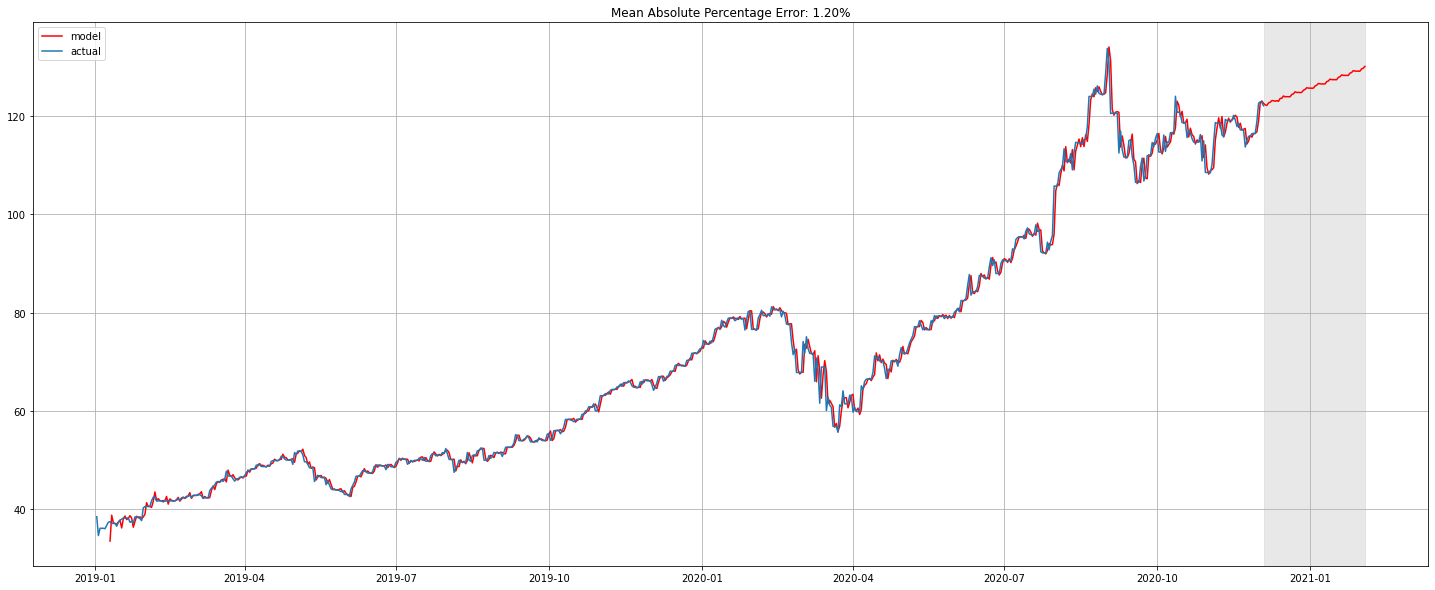

In [32]:
plotSARIMA(new_frame, best_model, 60)